In [1]:
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import accuracy
from sklearn.decomposition import NMF
from surprise.prediction_algorithms.random_pred import NormalPredictor
import seaborn as sns
from surprise.model_selection.split import train_test_split
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv("movies.csv",index_col=0)
ratings = pd.read_csv("ratings.csv",index_col=0)

# Reset the index to move movieId to a regular column
movies = movies.reset_index()

# Print the first 10 rows of the DataFrame to check the result
ratings.head(10)

,movieId,rating,timestamp
userId,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
1,70,3.0,964982400
1,101,5.0,964980868
1,110,4.0,964982176
1,151,5.0,964984041


In [3]:
ratings = ratings.reset_index()


In [4]:

# Extract the year from the title column using a regular expression
movies['year'] = movies['title'].str.extract('\((\d{4})\)', expand=False)

# Print the first 10 rows of the DataFrame to check the result
print(movies.head(10))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995  
5                        Action|Crime|Thriller  1995  
6                               Comedy|Romance  1995  
7        

## PreProcessing

In [5]:
min_ratings = 2 
min_ratings_count =  5 
# Delete movie rated under 2 
# Delete movie rated less than 5 times
movies = movies.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_ratings)
ratings = ratings.groupby("userId").filter(lambda x: x['userId'].count() >= min_ratings_count)


In [6]:
ratings.shape

(100836, 4)

In [7]:
movies.shape

(0, 4)

In [8]:
#!pip install scikit-surprise

### Train on a whole trainset and the predict() method

In [9]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields

# Surprise Dataset Load method
data = Dataset.load_from_df(ratings[["userId","movieId","rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()


In [10]:
trainset

### Tune algorithm parameters with GridSearchCV
I use the SVD algorithm from the Surprise library to make predictions on the MovieLens 100K dataset. I define a grid of hyperparameters to search over, and then use GridSearchCV to perform the search. GridSearchCV performs a 3-fold cross-validation for each combination of hyperparameters and computes the RMSE and MAE scores. Finally, it returns the best set of hyperparameters and the corresponding RMSE and MAE scores.

In [11]:
 ## checking the effect of number of latent factors k on the model's performance.
def rmse_vs_factors(algorithm, data):
    """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1) 100 values 
    Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
    """
    rmse_algorithm = []
    
    for k in range(1, 101, 1):
        algo = algorithm(n_factors = k)

        #["test_rmse"] is a numpy array with min accuracy value for each testset
        loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
        rmse_algorithm.append(loss_fce)
  
    return rmse_algorithm


In [12]:
rmse_svd = rmse_vs_factors(SVD,data)
rmse_svd

[0.8692462999818144,
 0.8700899631419183,
 0.8697298200598984,
 0.8698400468069704,
 0.8691570179484485,
 0.8697005444465147,
 0.8703789455237075,
 0.8698742020080988,
 0.870160540287344,
 0.869314784953718,
 0.8693467507708865,
 0.8688792715863372,
 0.8690531724563471,
 0.8696597006093043,
 0.8703817614650863,
 0.869289115644244,
 0.8695199320620424,
 0.8698689617570498,
 0.870179003769873,
 0.8695242752890644,
 0.8699910110083353,
 0.8682970067859092,
 0.8698309685183829,
 0.8708632391613488,
 0.8704041682585778,
 0.8704131218227367,
 0.8692277112555111,
 0.869972945959358,
 0.8692373901009072,
 0.8702536147666395,
 0.8699292679631727,
 0.869852905606366,
 0.8703416703292384,
 0.8708419469231371,
 0.8701221800624991,
 0.8707915696093277,
 0.8695183063455156,
 0.8712160518329398,
 0.8707133470139189,
 0.869717404361005,
 0.8700588015487934,
 0.8695707520187748,
 0.869444731829763,
 0.8706848461431091,
 0.8720181575313802,
 0.8704538152986,
 0.870481226639615,
 0.8703352771837718,
 0.8

In [13]:
def plot_rmse(rmse, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')
        
    plt.subplot(2,1,1)
    plt.plot(rmse)
    plt.xlim(0,100)
    plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(rmse)
    plt.xlim(0,50)
    plt.xticks(np.arange(0, 52, step=2))

    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse), color = "b")


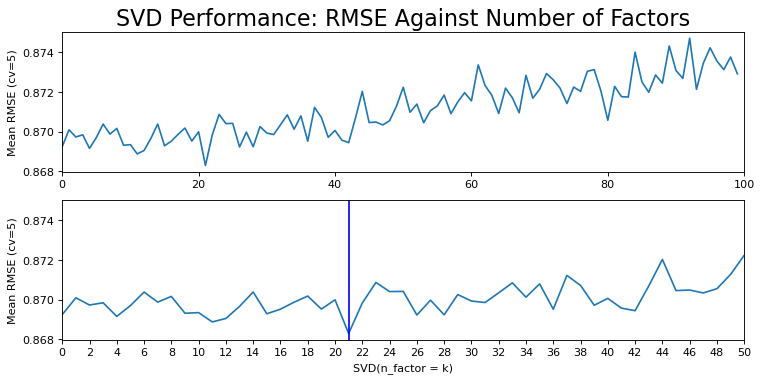

In [14]:
plot_rmse(rmse_svd,"SVD")

In [15]:
from collections import defaultdict

### Predictions using function 

In [16]:
# Define the testset
testset = data.build_full_trainset().build_testset()
# Train the SVD model
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
# Generate the predictions using the SVD model
predictions = svd.test(testset)


In [17]:
def get_top_n(predictions, userId, movies, ratings, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    
    #First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    
    #Tells how many movies the user has already rated
    user_data = ratings[ratings.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    old_usr = ratings[ratings.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return old_usr, pred_usr

In [18]:
old_SVD, pred_SVD = get_top_n(predictions, movies = movies, userId = 1, ratings = ratings)

User 1 has already rated 232 movies.


In [19]:
old_SVD, pred_SVD = get_top_n(predictions, movies=movies, userId=1, ratings=ratings)

User 1 has already rated 232 movies.


In [20]:
old_SVD.head(15)

,userId,movieId,rating,timestamp,title,genres,year
0,1,5060,5.0,964984002,NaN,NaN,NaN
1,1,2872,5.0,964981680,NaN,NaN,NaN
2,1,1291,5.0,964981909,NaN,NaN,NaN
3,1,1298,5.0,964984086,NaN,NaN,NaN
4,1,2948,5.0,964982191,NaN,NaN,NaN
5,1,2947,5.0,964982176,NaN,NaN,NaN
6,1,2944,5.0,964981872,NaN,NaN,NaN
7,1,2899,5.0,964982703,NaN,NaN,NaN
8,1,2858,5.0,964980868,NaN,NaN,NaN
9,1,2700,5.0,964980985,NaN,NaN,NaN


In [21]:
pred_SVD

,userId,movieId,rat_pred,title,genres,year
0,1,2959,4.665440,NaN,NaN,NaN
1,1,296,4.638376,NaN,NaN,NaN
2,1,50,4.627324,NaN,NaN,NaN
3,1,1213,4.624323,NaN,NaN,NaN
4,1,1208,4.617198,NaN,NaN,NaN
5,1,260,4.615086,NaN,NaN,NaN
6,1,1136,4.609795,NaN,NaN,NaN
7,1,1197,4.609363,NaN,NaN,NaN
8,1,1089,4.608550,NaN,NaN,NaN
9,1,2571,4.598616,NaN,NaN,NaN


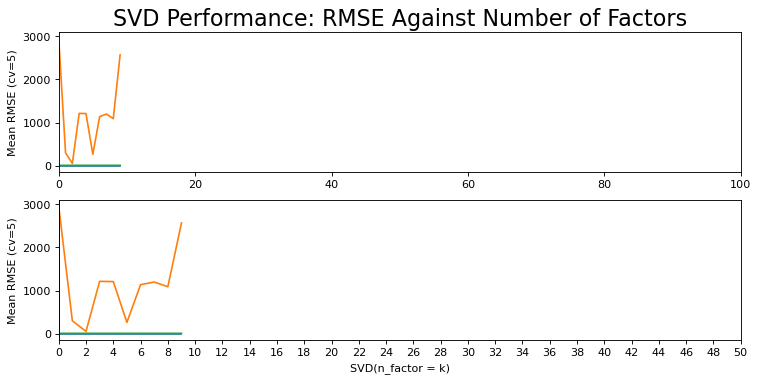

In [22]:
plot_rmse(pred_SVD,"SVD")